## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

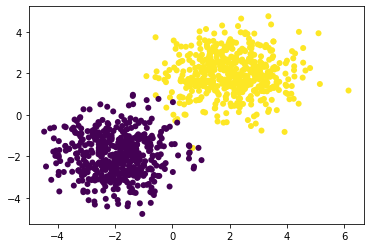

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
#net = Sequential()
#net.add(Linear(2, 2))
#net.add(LogSoftMax())

# Test something like that then 
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

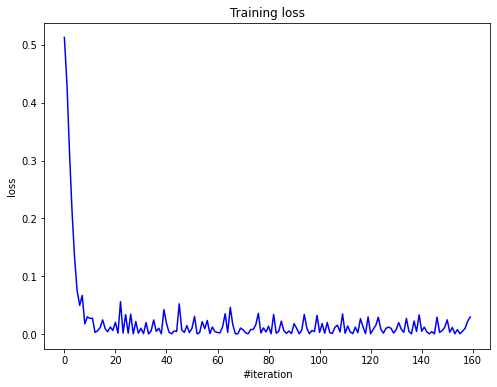

Current loss: 0.029564


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(y_train.reshape(-1,1))

y_train = ohe.transform(y_train.reshape(-1,1)).toarray()
y_val = ohe.transform(y_val.reshape(-1,1)).toarray()
y_test = ohe.transform(y_test.reshape(-1,1)).toarray()

X_train = X_train.reshape(-1, 28*28)
X_val = X_val.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

One-hot encode the labels first.

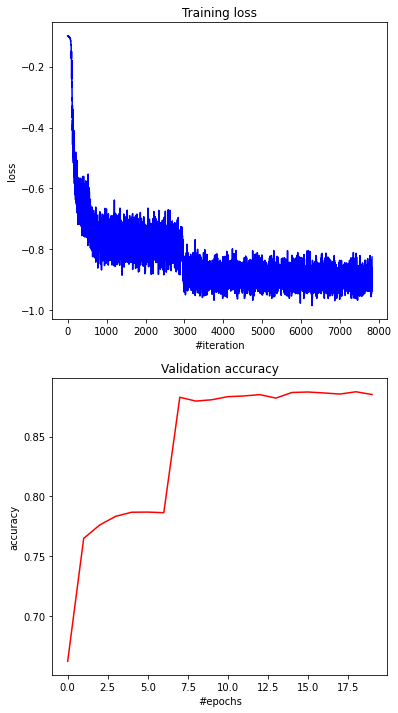

Current loss: -0.824931
Currenct val accuracy: 0.885400


In [10]:
net = Sequential()
net.add(Linear(28*28, 500))
net.add(ReLU())
net.add(Linear(500, 300))
net.add(ReLU())
net.add(Linear(300, 100))
net.add(ReLU())
net.add(Linear(100, 10))
net.add(SoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

n_epoch = 20
batch_size = 128

loss_history = []
acc_history = []

true_target = np.argmax(y_val, axis = 1)

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        
    predict = np.argmax(net.forward(X_val), axis=1)
    accuracy = np.sum(predict == true_target) / len(true_target)
    acc_history.append(accuracy)

    # Visualize
    display.clear_output(wait=True)

    plt.figure(figsize = (6, 12))

    plt.subplot(211)
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')

    plt.subplot(212)
    plt.title('Validation accuracy')
    plt.xlabel("#epochs")
    plt.ylabel("accuracy")
    plt.plot(acc_history, 'r')

    plt.show()
    
    print('Current loss: %f' % loss)
    print('Currenct val accuracy: %f' % accuracy)

In [11]:
test_target = np.argmax(y_test, axis = 1)
test_predict = np.argmax(net.forward(X_test), axis=1)
test_accuracy = np.sum(test_predict == test_target) / len(true_target)

print('Test accuracy: %f' % test_accuracy)

Test accuracy: 0.885000


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

ReLU time: 105.30009508132935
ELU time: 125.35894656181335
LeakyReLU time: 105.95300436019897
SoftPlus time: 127.58501052856445
ReLU + BatchNorm time: 133.8085994720459
ELU + BatchNorm time: 141.81718349456787
LeakyReLU + BatchNorm time: 136.83093237876892
SoftPlus + BatchNorm time: 133.84381318092346


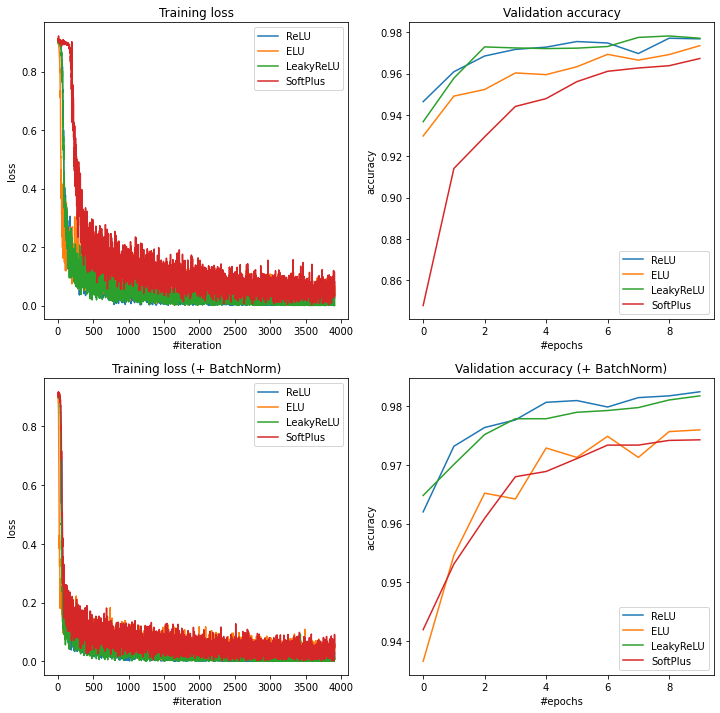

In [12]:
models = []

for activation_function in (ReLU, ELU, LeakyReLU, SoftPlus):
  net = Sequential()
  net.add(Linear(28*28, 500))
  net.add(activation_function())
  net.add(Linear(500, 300))
  net.add(activation_function())
  net.add(Linear(300, 100))
  net.add(activation_function())
  net.add(Linear(100, 10))
  net.add(SoftMax())
  models.append(net)

for activation_function in (ReLU, ELU, LeakyReLU, SoftPlus):
  net = Sequential()
  net.add(Linear(28*28, 500))
  net.add(ChannelwiseScaling(500))
  net.add(BatchNormalization())
  net.add(activation_function())
  net.add(Linear(500, 300))
  net.add(ChannelwiseScaling(300))
  net.add(BatchNormalization())
  net.add(activation_function())
  net.add(Linear(300, 100))
  net.add(ChannelwiseScaling(100))
  net.add(BatchNormalization())
  net.add(activation_function())
  net.add(Linear(100, 10))
  net.add(SoftMax())
  models.append(net)

N = 8

loss_history = [[] for _ in range(N)]
acc_history = [[] for _ in range(N)]

name_models = (
    'ReLU', 'ELU', 'LeakyReLU', 'SoftPlus',
    'ReLU + BatchNorm', 'ELU + BatchNorm', 'LeakyReLU + BatchNorm', 'SoftPlus + BatchNorm'
)

for idx, net in enumerate(models):
  start_time = time()

  criterion = MSECriterion()

  optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
  optimizer_state = {}

  n_epoch = 10
  batch_size = 128

  true_target = np.argmax(y_val, axis = 1)

  for i in range(n_epoch):
      for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
          
          net.zeroGradParameters()
          
          # Forward
          predictions = net.forward(x_batch)
          loss = criterion.forward(predictions, y_batch)
      
          # Backward
          dp = criterion.backward(predictions, y_batch)
          net.backward(x_batch, dp)
          
          # Update weights
          sgd_momentum(net.getParameters(), 
                      net.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      
          
          loss_history[idx].append(loss)
          
      predict = np.argmax(net.forward(X_val), axis=1)
      accuracy = np.sum(predict == true_target) / len(true_target)
      acc_history[idx].append(accuracy)

  print(f'{name_models[idx]} time: {time() - start_time}')

plt.figure(figsize = (12, 12))

plt.subplot(221)
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
for i in range(N // 2):
  plt.plot(loss_history[i], label=name_models[i])
plt.legend()

plt.subplot(222)
plt.title('Validation accuracy')
plt.xlabel("#epochs")
plt.ylabel("accuracy")
for i in range(N // 2):
  plt.plot(acc_history[i], label=name_models[i])
plt.legend()

plt.subplot(223)
plt.title("Training loss (+ BatchNorm)")
plt.xlabel("#iteration")
plt.ylabel("loss")
for i in range(N // 2, N):
  plt.plot(loss_history[i], label=name_models[i - N // 2])
plt.legend()

plt.subplot(224)
plt.title('Validation accuracy (+ BatchNorm)')
plt.xlabel("#epochs")
plt.ylabel("accuracy")
for i in range(N // 2, N):
  plt.plot(acc_history[i], label=name_models[i - N // 2])
plt.legend()

plt.show()

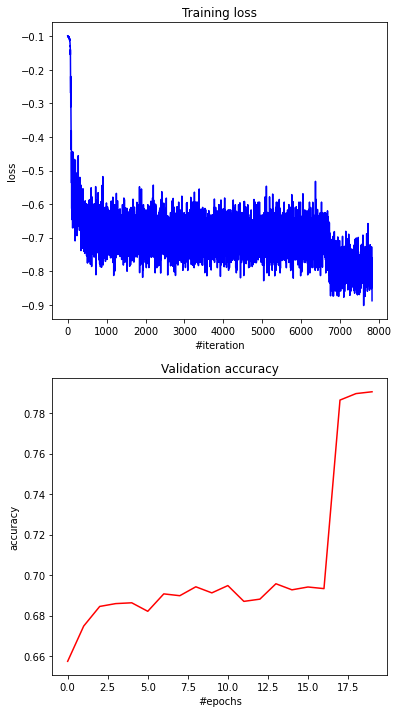

Current loss: -0.887482
Currenct val accuracy: 0.790600


In [13]:
net = Sequential()
net.add(Linear(28*28, 500))
net.add(ReLU())
net.add(Linear(500, 300))
net.add(ReLU())
net.add(Linear(300, 100))
net.add(ReLU())
net.add(Linear(100, 10))
net.add(SoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 0.005}
optimizer_state = {}

n_epoch = 20
batch_size = 128

loss_history = []
acc_history = []

true_target = np.argmax(y_val, axis = 1)

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        
    predict = np.argmax(net.forward(X_val), axis=1)
    accuracy = np.sum(predict == true_target) / len(true_target)
    acc_history.append(accuracy)

    # Visualize
    display.clear_output(wait=True)

    plt.figure(figsize = (6, 12))

    plt.subplot(211)
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')

    plt.subplot(212)
    plt.title('Validation accuracy')
    plt.xlabel("#epochs")
    plt.ylabel("accuracy")
    plt.plot(acc_history, 'r')

    plt.show()
    
    print('Current loss: %f' % loss)
    print('Currenct val accuracy: %f' % accuracy)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Answer: The network with ELU or SoftMax is trained longer than the others, BatchNorm slows down network training for a few seconds, but at the same time high quality is achieved much earlier. SoftPlus loss decreases the slowest, which affects the quality of the model. On this network architecture and this dataset, momentum_sgd performed better than adam

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

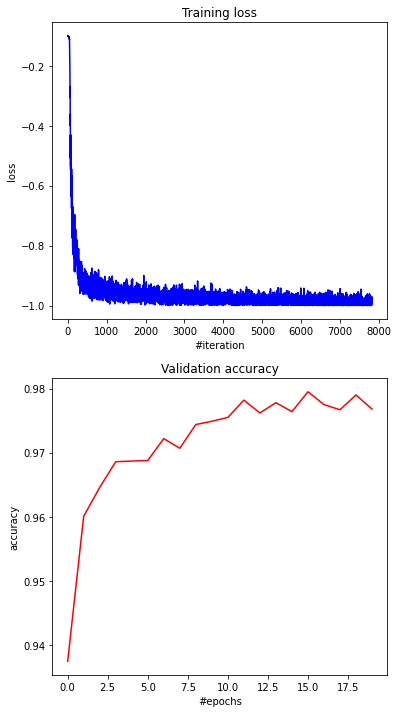

Current loss: -0.974607
Currenct val accuracy: 0.976800

Test accuracy: 0.976800


In [14]:
net = Sequential()
net.add(Linear(28*28, 500))
net.add(ChannelwiseScaling(500))
net.add(BatchNormalization())
net.add(ReLU())
net.add(Linear(500, 300))
net.add(Dropout(0.5))
net.add(ReLU())
net.add(Linear(300, 100))
net.add(ChannelwiseScaling(100))
net.add(BatchNormalization())
net.add(ReLU())
net.add(Linear(100, 10))
net.add(SoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 0.005}
optimizer_state = {}

n_epoch = 20
batch_size = 128

loss_history = []
acc_history = []

true_target = np.argmax(y_val, axis = 1)

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        
    predict = np.argmax(net.forward(X_val), axis=1)
    accuracy = np.sum(predict == true_target) / len(true_target)
    acc_history.append(accuracy)

    # Visualize
    display.clear_output(wait=True)

    plt.figure(figsize = (6, 12))

    plt.subplot(211)
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')

    plt.subplot(212)
    plt.title('Validation accuracy')
    plt.xlabel("#epochs")
    plt.ylabel("accuracy")
    plt.plot(acc_history, 'r')

    plt.show()
    
    print('Current loss: %f' % loss)
    print('Currenct val accuracy: %f' % accuracy)

test_target = np.argmax(y_test, axis = 1)
test_predict = np.argmax(net.forward(X_test), axis=1)
test_accuracy = np.sum(test_predict == test_target) / len(true_target)

print('\nTest accuracy: %f' % test_accuracy)

Print here your accuracy on test set. It should be around 90%.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [15]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=128,
                                         shuffle=True,
                                         num_workers=2)

In [16]:
def learning(model, opt, loss_func, n_epochs, train_loader, test_loader):
  print('Info:')
  torchsummary.summary(model, (28*28,))
  print('Train: ')
  loss_train_array, loss_test_array = [], []
  accuracy_test_array, accuracy_train_array = [], []

  for epoch in range(n_epochs):
    accuracy_train = accuracy_test = mean_loss_test = mean_loss_train = 0

    for x_batch, y_batch in train_loader:
      y_pred = model.forward(x_batch)

      loss = loss_func(y_pred, y_batch)

      opt.zero_grad()

      loss.backward()

      opt.step()

      accuracy_train += (y_batch == y_pred.argmax(axis=0)).float().sum()
      mean_loss_train += loss
    accuracy_train /= len(train_dataset)
    mean_loss_train /= len(train_dataset)
    accuracy_train_array.append(accuracy_train)
    loss_train_array.append(mean_loss_train)

    for x_batch, y_batch in test_loader:
      y_pred = model.forward(x_batch)
      accuracy_test += (y_batch == y_pred.argmax(axis=0)).float().sum()
      mean_loss_test += loss_func(y_pred, y_batch)
    accuracy_test /= len(val_dataset)
    mean_loss_test /= len(val_dataset)
    accuracy_test_array.append(accuracy_test)
    loss_test_array.append(mean_loss_test)

    print(f'epoch = {epoch+1}/{n_epochs}, acc_train = {accuracy_train:.4f}, acc_test = {accuracy_test:.4f}, loss_train = {mean_loss_train:.4f}, loss_test = {mean_loss_test:.4f}')

  print('Plots:')
  plt.figure(figsize = (12, 6))

  plt.subplot(121)
  plt.title('Accuracy')
  plt.plot(accuracy_test_array, label='test')
  plt.plot(accuracy_train_array, label='train')
  plt.legend()

  plt.subplot(122)
  plt.title('Loss')
  plt.plot(loss_test_array, label='test')
  plt.plot(loss_train_array, label='train')
  plt.legend()

  plt.show()

In [17]:
class Net(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

Info:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
       BatchNorm1d-2                  [-1, 500]           1,000
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 300]         150,300
           Dropout-5                  [-1, 300]               0
              ReLU-6                  [-1, 300]               0
            Linear-7                  [-1, 100]          30,100
       BatchNorm1d-8                  [-1, 100]             200
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
          Softmax-11                   [-1, 10]               0
Total params: 575,110
Trainable params: 575,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

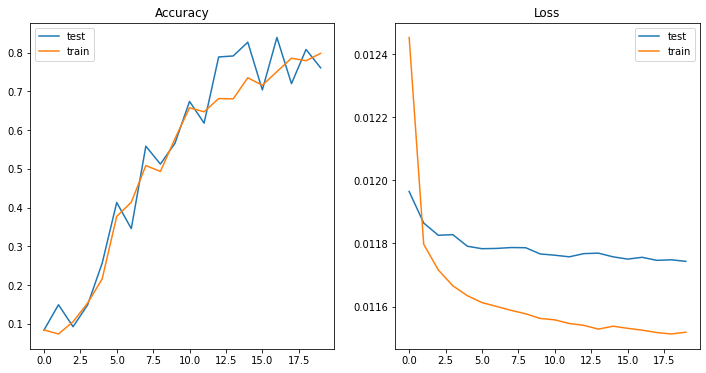

In [18]:
model = Net()
opt = torch.optim.Adam(model.model.parameters())
loss_func = nn.CrossEntropyLoss()

learning(model=model,
         opt=opt,
         loss_func=loss_func,
         n_epochs=20,
         train_loader=train_loader,
         test_loader=val_loader)

In [19]:
test_target = np.argmax(y_test, axis = 1)
test_predict = np.argmax(model.forward(torch.tensor(X_test)).data.numpy(), axis=1)
test_accuracy = np.sum(test_predict == test_target) / len(true_target)

print('\nTest accuracy: %f' % test_accuracy)


Test accuracy: 0.978100
